# 🔢 MNIST Image Embeddings — Similarity & Retrieval

Professional, English notebook. Minimal narration, technical comments only.


**Sections**
1. Imports  
2. Data Loading and Preprocessing  
3. Embedding Model Definition
4. Embedding Visualization with t-SNE  
5. Embedding Exploration
6. Similarity Index (k-NN)  
7. Similarity Search & Retrieval  
8. Evaluation

## 1. Imports

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.datasets import mnist

import cv2 
import numpy as np
import matplotlib.pyplot as plt

## 2. Data Loading and Preprocessing
Load and preprocess the MNIST dataset (70k handwritten digits of 28x28 pixels).

In [7]:
def load_data(n=5000):

    (x_train, y_train), (_, _) = mnist.load_data()

    x_train = x_train[:n]  
    y_train = y_train[:n]

    x_train = x_train.astype("float32") / 255.0      # Normalize pixel values to [0, 1]
    x_train = np.expand_dims(x_train, axis=-1)       # Add channel dimension to work with CNNs
    x_train = np.tile(x_train, (1, 1, 1, 3))         # Convert from grayscale to 3 channels (RGB)

    return x_train, y_train

## 3. Embedding Model Definition
Build a feature embedding model based on VGG16 (without the original classification head).

In [8]:
def create_embedding_model():
    # Load VGG16 with include_top=False, to remove the final classification head
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

    inputs = Input(shape=(32, 32, 3), name="image_input")
    x = base_model(inputs)
    x = Flatten(name="flatten_features")(x)
    outputs = Dense(128, activation="relu", name="embedding")(x)
    model = Model(inputs=inputs, outputs=outputs, name="vgg16_embedding_model")

    return model


## 4. Embedding Visualization with t-SNE
Reduce embedding dimensionality to 2D using t-SNE and visualize them.

In [9]:
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=31, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title("2D Visualization of Embeddings using t-SNE")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid()
    plt.show()

## 5. Embedding Exploration

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step


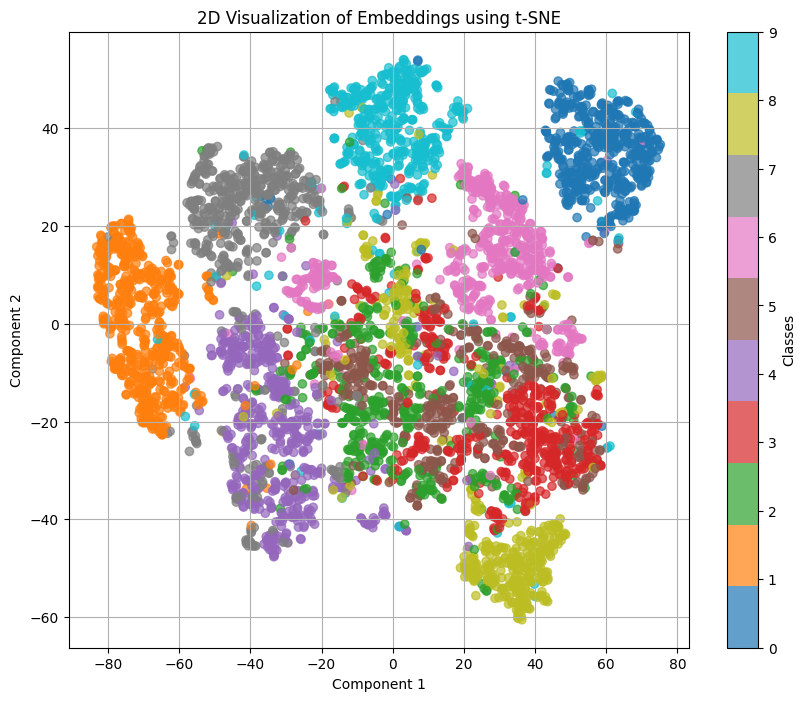

In [10]:
# main execution
x_train, y_train = load_data(5000)
x_train_resized = np.array([cv2.resize(img, (32, 32)) for img in x_train])
model = create_embedding_model()
embeddings = model.predict(x_train_resized)
visualize_embeddings(embeddings, y_train)

## 6. Similarity Index (k-NN)

In [11]:
from sklearn.neighbors import NearestNeighbors

knn_index = NearestNeighbors(n_neighbors=6, metric="euclidean")
knn_index.fit(embeddings)
print("Index built on", embeddings.shape[0], "vectors")

Index built on 5000 vectors


## 7) Similarity Search & Retrieval

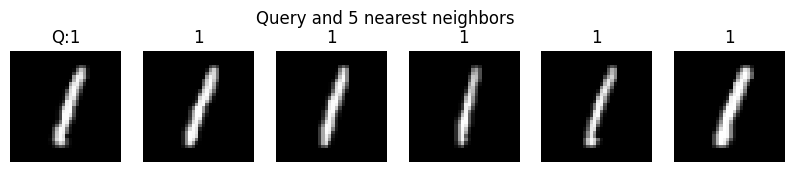

In [12]:
import random

k = 5
q_idx = random.randrange(len(embeddings))
dist, ind = knn_index.kneighbors(embeddings[q_idx:q_idx+1], n_neighbors=k+1)
ind = [i for i in ind[0] if i != q_idx][:k]

plt.figure(figsize=(10, 2))
plt.subplot(1, 6, 1)
plt.imshow(x_train_resized[q_idx])
plt.title(f"Q:{int(y_train[q_idx])}")
plt.axis("off")

for j, idx in enumerate(ind, start=2):
    plt.subplot(1, 6, j)
    plt.imshow(x_train_resized[idx])
    plt.title(f"{int(y_train[idx])}")
    plt.axis("off")

plt.suptitle("Query and 5 nearest neighbors")
plt.show()

## 8. Evaluation

In [13]:
test_size = 1000
test_idx = np.arange(test_size)
train_idx = np.arange(test_size, len(embeddings))

emb_train = embeddings[train_idx]
y_train_split = y_train[train_idx]
emb_test = embeddings[test_idx]
y_test_split = y_train[test_idx]

from sklearn.neighbors import NearestNeighbors
nn1 = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(emb_train)
dist, idxs = nn1.kneighbors(emb_test, n_neighbors=1)

pred = y_train_split[idxs[:, 0]]
acc = (pred == y_test_split).mean()

print(f"1-NN accuracy on embeddings (train={len(train_idx)}, test={len(test_idx)}): {acc:.4f}")

1-NN accuracy on embeddings (train=4000, test=1000): 0.8700
